In [1]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import requests
import json

In [2]:
#load in csv
olympics_data = pd.read_csv("Summer-Olympic-medals-1976-to-2008.csv", encoding="latin-1")
olympics_data.head()

,City,Year,Sport,Discipline,Event,Athlete,Gender,Country_Code,Country,Event_gender,Medal
0,Montreal,1976.0,Aquatics,Diving,3m springboard,"KÖHLER, Christa",Women,GDR,East Germany,W,Silver
1,Montreal,1976.0,Aquatics,Diving,3m springboard,"KOSENKOV, Aleksandr",Men,URS,Soviet Union,M,Bronze
2,Montreal,1976.0,Aquatics,Diving,3m springboard,"BOGGS, Philip George",Men,USA,United States,M,Gold
3,Montreal,1976.0,Aquatics,Diving,3m springboard,"CAGNOTTO, Giorgio Franco",Men,ITA,Italy,M,Silver
4,Montreal,1976.0,Aquatics,Diving,10m platform,"WILSON, Deborah Keplar",Women,USA,United States,W,Bronze


In [3]:
# Assign Medal Counts
medal_dict = {'Gold':3,'Silver':2,'Bronze':1}
olympics_data['Points'] = olympics_data['Medal'].map(medal_dict)

In [4]:
# Load in Host Country CSV, merge with Olympics Data Frame
host_country_df = pd.read_csv('Host_Countries.csv')
host_country_df = host_country_df[['Year','Country']]
host_country_df.rename(columns={'Country':'Host Country'},inplace=True)
olympics_data = olympics_data.merge(host_country_df,on='Year')

In [5]:
# Get pt Total DF by year
pt_total_df = olympics_data.groupby('Year').sum()

In [6]:
# Find Host Years and Host City, Country

host_years = olympics_data['Year'].unique()

year_countries_dict = {}
for i in host_years:
    if i == 1988.0:
        year_countries_dict[i] = 'Korea, South'
    elif i == 1980.0:
        year_countries_dict[i] = 'Soviet Union'
    else:
        year_countries_dict[i] = olympics_data[olympics_data['Year']==i]['Host Country'].unique()[0]
        
# Create DF with only host countries

host_countries = []
for k,v in year_countries_dict.items():
    host_countries.append(v)

host_df = olympics_data[olympics_data['Country'].isin(host_countries)]

# Build Data Frame with a Year index and Host Country Point Totals as Columns

frame = pd.DataFrame(index=host_years)

for year in host_years:
    country = year_countries_dict[year]

    to_add = host_df[host_df['Country']==country].groupby('Year').sum()
    to_add.rename(columns={'Points':country},level=0,inplace=True)
    frame = frame.merge(to_add,how='outer',left_index=True,right_index=True)

frame.rename(columns={'United States_x':'United States'},inplace=True)
frame = frame[['Canada','Soviet Union','United States','Korea, South','Spain','Australia','Greece','China']]

In [7]:
# Get Soviet Union/Russia Point Totals. Fill DF

sov_union = olympics_data[olympics_data['Country']=='Soviet Union'].groupby('Year').sum()
russia = olympics_data[olympics_data['Country']=='Russia'].groupby('Year').sum()
unif_team = olympics_data[olympics_data['Country']=='Unified team'].groupby('Year').sum()

sov_union_russia = sov_union.append(russia)
sov_union_russia = sov_union_russia.append(unif_team)
sov_union_russia = sov_union_russia.sort_index()

l = sov_union_russia['Points'].values
sov_rus_pts = []

for i in range(2):
    sov_rus_pts.append(float(l[i]))
sov_rus_pts.append(np.nan)
for i in range(2,8):
    sov_rus_pts.append(float(l[i]))

frame['Soviet Union/Russia'] = sov_rus_pts

frame = frame[['Canada', 'Soviet Union/Russia', 'United States', 'Korea, South', 'Spain',
       'Australia', 'Greece', 'China']]

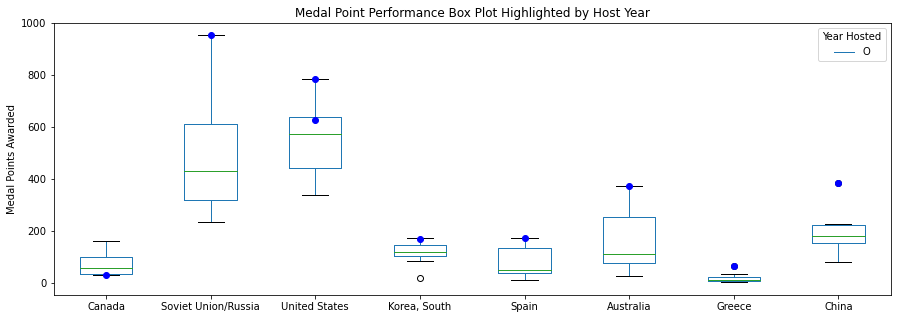

In [8]:
# Boxplot by Host Country

x = ['Canada', 'Soviet Union/Russia', 'United States', 'Korea, South', 'Spain',
       'Australia', 'Greece', 'China']
y = [28,953,784,628,170,174,372,65,385]

frame[frame.columns].plot(kind='box',figsize=(15,5))
plt.title('Medal Point Performance Box Plot Highlighted by Host Year')
plt.ylabel('Medal Points Awarded')
# plt.xlabel('Host Countries from 1976 - 2008')
plt.plot([1,2,3,3,4,5,6,7,8],y,'bo')

plt.legend(labels='O'[0],title='Year Hosted');

In [9]:
# Geographical Plotting

host_country_df['City'] = olympics_data['City'].unique()
host_country_df['Search'] = host_country_df['City']+', '+host_country_df['Host Country']

# Get Lat and Long

from config import g_key

city_dict = {}

search_items = []
for i in host_country_df['Search'].values:
    search_items.append(i)

# Build URL using the Google Maps API
base_url = "https://maps.googleapis.com/maps/api/geocode/json"

for item in search_items:
    
    params = {"address": item, "key": g_key}
    
    response = requests.get(base_url, params=params)

    geo = response.json()

    lat = geo["results"][0]["geometry"]["location"]["lat"]
    lng = geo["results"][0]["geometry"]["location"]["lng"]

    city_dict[item] = (lat,lng)
    
# Build Lat and Lng in DataFrame

host_country_df['LAT'] = host_country_df['Search'].apply(lambda x: city_dict[x][0])
host_country_df['LNG'] = host_country_df['Search'].apply(lambda x: city_dict[x][1])

In [10]:
# Find Missing Years

missing_years = {'Canada':[], 'Soviet Union/Russia':[], 'United States':[], 'Korea, South':[],
       'Spain':[], 'Australia':[], 'Greece':[], 'China':[]}

for k in missing_years:
    try:
        y = frame[frame[k].isna()==True][k].index[0]
        missing_years[k].append(y)
    except:
        pass

In [11]:
# Inport new dependencies

import math
import gmaps

In [12]:
# Build Function to Calc Weights for Heat Map

def Build_weights(country_select='United States',metric='average'):
    
    country_points = []

    country_mean = frame[country_select].mean()

    for pts in frame[country_select]:
        country_points.append(pts)

    weight = []

    if metric == 'average':

        met = frame[country_select].mean()

        for i in range(9):
            if math.isnan(country_points[i])==True:
                met = .01
                weight.append(met)
            else:
                met = (country_points[i]/country_mean)*100
                weight.append(met)

    if metric == 'percent':
        count = olympics_data.groupby('Year').sum()

        d = count.to_dict()
        d = d['Points'].values()
        avges = []
        for i in d:
            avges.append(i)

        for i in range(9):
            if math.isnan(country_points[i])==True:
                met = .01
                weight.append(met)
            else:
                met = (country_points[i]/avges[i])*100
                weight.append(met)
                    
    return weight

In [13]:
# Show Heatmap of Host Country Point Totals
# Get Country and Weight Method

country_select = input('What Host Country: ')
metric = input('(percent) or (average)')

# Find point index from country average or point index from year's points available
weight = Build_weights(country_select,metric)

# Build Map         
            
gmaps.configure(api_key=g_key)
locations = host_country_df[["LAT", "LNG"]]


# Plot Heatmap
fig = gmaps.figure()
fig.figzize=(15,5)

# Create heat layer

heat_layer = gmaps.heatmap_layer(locations, weights=weight,
                                 dissipating=False, max_intensity=max(weight),
                                 point_radius=5)

# Add layer
fig.add_layer(heat_layer)

# Display figure
print(country_select)
fig

What Host Country: United States
(percent) or (average)average
United States


Figure(layout=FigureLayout(height='420px'))

In [14]:
frame

,Canada,Soviet Union/Russia,United States,"Korea, South",Spain,Australia,Greece,China
1976.0,28.0,604.0,337.0,20.0,12.0,40.0,NaN,NaN
1980.0,NaN,953.0,NaN,NaN,47.0,24.0,7.0,NaN
1984.0,159.0,NaN,784.0,83.0,37.0,78.0,3.0,141.0
1988.0,34.0,627.0,411.0,170.0,9.0,76.0,1.0,81.0
1992.0,103.0,472.0,452.0,110.0,174.0,112.0,6.0,165.0
1996.0,98.0,232.0,628.0,135.0,136.0,212.0,20.0,222.0
2000.0,43.0,388.0,574.0,123.0,69.0,372.0,32.0,180.0
2004.0,33.0,335.0,571.0,108.0,50.0,333.0,65.0,225.0
2008.0,69.0,273.0,674.0,171.0,133.0,253.0,10.0,385.0


In [47]:
last_two_hc = ['United Kingdom','Brazil']
uk_df = olympics_data[olympics_data['Country']==last_two_hc[0]].groupby(['Year']).sum()
p = {'Points':{2012.0:140,2016.0:144}}
points = pd.DataFrame(p)
uk_df = uk_df.append(points)

braz_df = olympics_data[olympics_data['Country']==last_two_hc[1]].groupby(['Year']).sum()
p = {'Points':{2012.0:28,2016.0:39}}
points = pd.DataFrame(p)
braz_df = braz_df.append(points)